# Projeto prática 1 - Panda
Grupo de Processamento de Linguagem Natural

Aprendizado de máquina supervisionado - Classificação.

Ciclo 1 - 2023

Autor: Leticia Bossatto Marchezi - BCC 020. UFSCar São Carlos. [Acesso ao linkedin](linkedin.com/in/letmarchezi/)

Data: 17/08/2023

Instalação dos pacotes necessários

In [1]:
!pip install matplotlib nltk pandas seaborn wordcloud keras tensorflow

In [68]:
# Importacao das bibliotecas e funcoes utilizadas
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import re
import regex
import string
import numpy as np
import pandas as pd
import unidecode
import seaborn as sns
import contractions
from tweets_preprocess import Preprocess
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

# Corpus: Twitter Sentiment Analysis

Coleção de 1600000 tweets para a tarefa de análise de sentimentos

Disponível em: [Kaggle](https://www.kaggle.com/datasets/raj713335/twittesentimentanalysis)

Atributos:

- ids: The id of the tweet

- date: the date of the tweet 

- flag: The query. If there is no query, then this value is NO_QUERY.

- user: The user that tweeted

- **text:** the text of the tweet

- **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)


In [4]:
df = pd.read_csv('tweets.csv',names=["target","id","date","flag","user","tweet"])

In [5]:
df.head()

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Apenas o target e o texto do tweet serão utilizados na tarefa.

In [7]:
df.drop(columns=["id","date","flag","user"],inplace=True)

O dataset apenas possui as classes 0(negativo) e 4(positivo) e está balanceado

In [8]:
print(df.groupby('target').size())

target
0    800000
4    800000
dtype: int64


## Pré-processamento

Alterando os targets para -1 (negativo) e 1 (positivo):

In [9]:
df.loc[df["target"] == 4,["target"]]=1
df.loc[df["target"] == 0,["target"]]=-1

In [10]:
print(df.groupby('target').size())

target
-1    800000
 1    800000
dtype: int64


Escolhendo uma amostra menor para trabalhar, com 10.000 registros:

In [11]:
df=df.sample(10000, random_state=42).reset_index(drop=True)

### Normalização:

[**tweets-preprocess 0.2.4**](https://pypi.org/project/tweets-preprocess/)

Limpa:
- URLs
- Hashtags
- Mentions
- Emojis
- Smileys

In [12]:
# Modulo de 'tweets-preprocess' combinando com outros processamentos
def preprocess_lib(data,column_name):
    punctuation_table = str.maketrans('','',string.punctuation)
    stop_words = set(stopwords.words('english'))
    stop_words.update(["&","lt" ,"gt","@"] )


    EMAIL_REGEX_STR = r'\S*@\S*' # remove emails
    MENTION_REGEX_STR = r'@\S*' # remove @
    HASHTAG_REGEX_STR = r'#\S+' # remove simbolo de hashtags
    URL_REGEX_STR = r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*' # remove urls

    ### Preprocessing 
    texts = data[column_name].values.tolist()
    # remove pontuação
    texts = [sentence.translate(punctuation_table).lower() for sentence in texts]
    # filtra regex
    remove_regex = regex.compile(f'({EMAIL_REGEX_STR}|{MENTION_REGEX_STR}|{HASHTAG_REGEX_STR}|{URL_REGEX_STR})')
    texts = [regex.sub(remove_regex, '', text) for text in texts]
    texts = [text.strip() for text in texts]
    # filtra textos com menos de 35 caracteres
    

    emoj = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                    "]+", re.UNICODE)
    # remove emojis
    texts = [re.sub(emoj, '', i) for i in texts]

    # tokeniza o texto, abre as contrações, remove stopwords e elimina tweets com menos de 35 caracteres
    tokens = [word_tokenize(text) for text in texts]
    texts = [[contractions.fix(token) for token in sublist] for sublist in tokens]  
    texts = [[word for word in sublist if not word in stop_words and len(word)>1] for sublist in texts]
    texts = [' '.join(text) for text in texts]
    texts = [text if len(text)>35 else "" for text in texts] #
    
    return texts  

Como alguns tweets possuem menos de 35 caracteres, eles foram substituidos por uma string vazia

In [13]:
df["preprocessed"] = preprocess_lib(df,"tweet")
df[["tweet","preprocessed"]].head()

,tweet,preprocessed
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,
1,"@misstoriblack cool , i have no tweet apps for my razr 2",
2,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",tiannachaos know family drama lamehey next time hang kim guys like sleepover whatever ill call
3,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,school email will not open geography stuff revise stupid school
4,upper airways problem,


Remoção das strings vazias

In [14]:
filter = df["preprocessed"] != ""
df = df[filter].reset_index(drop=True)
df.head()

,target,tweet,preprocessed
0,-1,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",tiannachaos know family drama lamehey next time hang kim guys like sleepover whatever ill call
1,-1,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,school email will not open geography stuff revise stupid school
2,-1,gahh noo!peyton needs to live!this is horrible,gahh noopeyton needs livethis horrible
3,1,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitting it!,mrstessyman thank glad like product review bit site enjoy knitting
4,1,@PerezHilton Zach makes me pee sitting down! And I'm a grown gay man!,perezhilton zach makes pee sitting i am grown gay man


## Visualização dos dados

Como algumas linhas foram removidas no passo anterior, há um pequeno desequilíbrio entre as classes

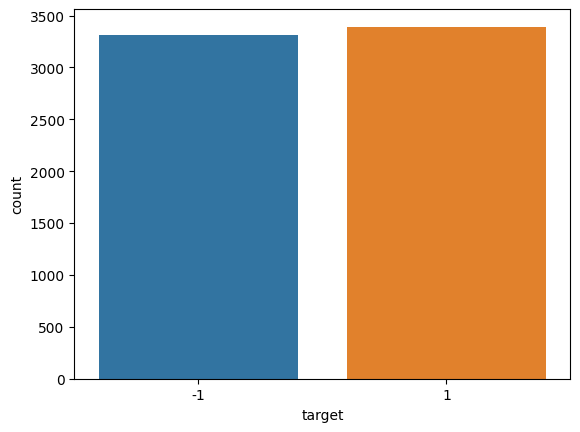

In [15]:
# Plot do gráfico por categoria ('target')
sns.countplot(x=df['target'],label="Count")
plt.show()

### Wordcloud

In [16]:
# Funcao que cria um WordCloud de uma coluna textual de um dataset
def create_wordcloud(df, text_column, color='blue'):

    text = ' '.join(df[text_column].astype(str))
    word_cloud = WordCloud(width=3000,
                           height=2000,
                           random_state=1,
                           background_color=color,
                           collocations=False).generate(text)

    # Conversao do WordCloud em um array NumPy (imagem)
    return word_cloud.to_array()

Criacao do WordCloud do corpus inteiro

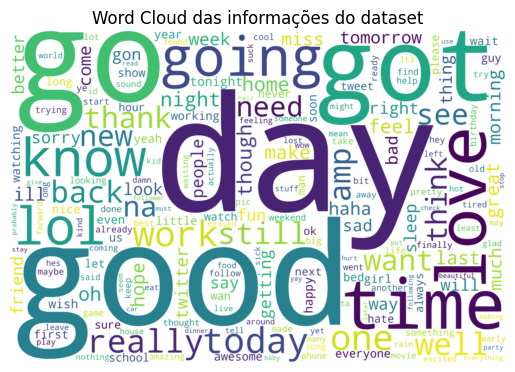

In [17]:
word_cloud_image = create_wordcloud(df, 'preprocessed', color='white')

# Plot
plt.imshow(word_cloud_image, interpolation='bilinear')
plt.title('Word Cloud das informações do dataset')
plt.axis('off')
plt.show()

Criação do wordcloud de cada classe do dataset

In [18]:
wordcloud_neg = create_wordcloud(df[df['target'] == -1], 'preprocessed', color='blue')
wordcloud_pos = create_wordcloud(df[df['target'] == 1], 'preprocessed', color='orange')

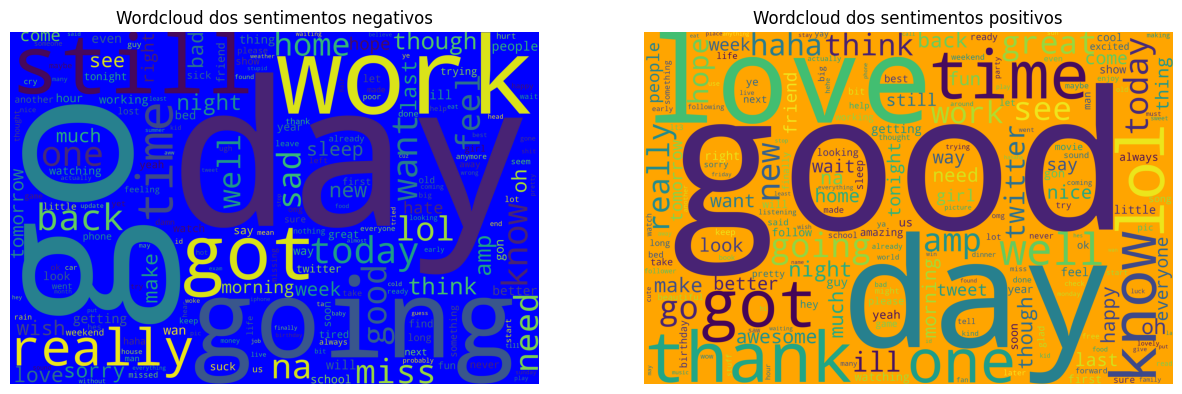

In [19]:
plt.figure(figsize=(15, 15))
# subplots
plt.subplot(2, 2, 1)
plt.title("Wordcloud dos sentimentos negativos")
plt.imshow(wordcloud_neg)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Wordcloud dos sentimentos positivos")
plt.imshow(wordcloud_pos)
plt.axis("off")

plt.show()

## Stemmer

Extrai o sufixo das palavras, usado para facilitar a associação entre palavras com sentidos próximos.

In [20]:
stemmer = PorterStemmer() # Instanciação do stemmer

Tokenização dos tweets processados

In [21]:
df['preprocessed'] = [word_tokenize(line) for line in df['preprocessed']]

Aplicacao do stemmer pra cada palavra (token)

In [22]:
df['stemmed'] = [[stemmer.stem(token) for token in sublist] for sublist in df["preprocessed"]]  
df.head()

,target,tweet,preprocessed,stemmed
0,-1,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u","[tiannachaos, know, family, drama, lamehey, next, time, hang, kim, guys, like, sleepover, whatever, ill, call]","[tiannachao, know, famili, drama, lamehey, next, time, hang, kim, guy, like, sleepov, whatev, ill, call]"
1,-1,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,"[school, email, will, not, open, geography, stuff, revise, stupid, school]","[school, email, will, not, open, geographi, stuff, revis, stupid, school]"
2,-1,gahh noo!peyton needs to live!this is horrible,"[gahh, noopeyton, needs, livethis, horrible]","[gahh, noopeyton, need, livethi, horribl]"
3,1,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitting it!,"[mrstessyman, thank, glad, like, product, review, bit, site, enjoy, knitting]","[mrstessyman, thank, glad, like, product, review, bit, site, enjoy, knit]"
4,1,@PerezHilton Zach makes me pee sitting down! And I'm a grown gay man!,"[perezhilton, zach, makes, pee, sitting, i, am, grown, gay, man]","[perezhilton, zach, make, pee, sit, i, am, grown, gay, man]"


Frequência de ocorrências dos tokens nas sentenças após o stemming:

In [23]:
df['stemmed'].apply(FreqDist)

0       {'tiannachao': 1, 'know': 1, 'famili': 1, 'drama': 1, 'lamehey': 1, 'next': 1, 'time': 1, 'hang': 1, 'kim': 1, 'guy': 1, 'like': 1, 'sleepov': 1, 'whatev': 1, 'ill': 1, 'call': 1}
1                                                                            {'school': 2, 'email': 1, 'will': 1, 'not': 1, 'open': 1, 'geographi': 1, 'stuff': 1, 'revis': 1, 'stupid': 1}
2                                                                                                                        {'gahh': 1, 'noopeyton': 1, 'need': 1, 'livethi': 1, 'horribl': 1}
3                                                               {'mrstessyman': 1, 'thank': 1, 'glad': 1, 'like': 1, 'product': 1, 'review': 1, 'bit': 1, 'site': 1, 'enjoy': 1, 'knit': 1}
4                                                                             {'perezhilton': 1, 'zach': 1, 'make': 1, 'pee': 1, 'sit': 1, 'i': 1, 'am': 1, 'grown': 1, 'gay': 1, 'man': 1}
                                                            

Criação de um novo dataset contendo apenas os textos pré-processados com e sem stemming (basic [tokenizado] e stemmed)

A coluna *'basic'* será utilizada para word embeddings e a coluna *'stemmed'* para TFIDF e Bag-of-words

In [24]:
df_processed = pd.DataFrame(df[["preprocessed","stemmed","target"]], columns=["basic","stemmed","target"])

df_processed["basic"]=[' '.join(text) for text in df["preprocessed"]]
df_processed["stemmed"]=[' '.join(text) for text in df["stemmed"]]

In [25]:
df_processed.head()

,basic,stemmed,target
0,tiannachaos know family drama lamehey next time hang kim guys like sleepover whatever ill call,tiannachao know famili drama lamehey next time hang kim guy like sleepov whatev ill call,-1
1,school email will not open geography stuff revise stupid school,school email will not open geographi stuff revis stupid school,-1
2,gahh noopeyton needs livethis horrible,gahh noopeyton need livethi horribl,-1
3,mrstessyman thank glad like product review bit site enjoy knitting,mrstessyman thank glad like product review bit site enjoy knit,1
4,perezhilton zach makes pee sitting i am grown gay man,perezhilton zach make pee sit i am grown gay man,1


### Preparação de Word Embeddings
Representa os tokens(palavras) em um espaço vetorial


Sugestões de estudo sobre embeddings/word2vec:

https://kavita-ganesan.com/easily-access-pre-trained-word-embeddings-with-gensim/

https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

#### Abordagem 1: Treinamento do próprio modelo com o dataset*
*Apenas para demonstração, não será utilizado no testes

In [26]:
!pip install gensim

In [27]:
from gensim.models import Word2Vec

Criação do vocabulário e treinamento do modelo word2vec (embeddings)

In [28]:
model = Word2Vec(df_processed["basic"], vector_size=100, window=5, min_count=1, workers=8)
model.build_vocab(df_processed["basic"])
model.train(df_processed["basic"], total_examples=model.corpus_count, epochs=model.epochs)

(395176, 2153260)

Salva e carrega os modelos

In [29]:
# model.save("word2vec_model.model")
# loaded_model = Word2Vec.load("word2vec_model.model")

Mostra as palavras mais similares ao token "tweet

In [30]:
#model.wv.most_similar("tweet")

Representação vetorial da palavra "world"

In [31]:
#print(model.wv["world"])

In [32]:
#embedding_matrix = model.wv[model.wv.key_to_index]
#print(len(embedding_matrix))

To be continued...

#### Abordagem 2: utilização de um modelo pré-treinado:

**Este será utilizado para os testes**

Modelo de embeddings pré-treinado glove-twitter-25 

Possui 25 dimensões 

In [34]:
import gensim.downloader as api
model_glove_twitter = api.load("glove-twitter-25")

In [35]:
model_glove_twitter.save("model_glove_twitter.model")

In [36]:
model_glove_twitter.most_similar("tweet",topn=10)

[('twitter', 0.9403422474861145),
 ('tweets', 0.9049733877182007),
 ('fb', 0.9014942646026611),
 ('tl', 0.8849644660949707),
 ('hashtag', 0.8799343109130859),
 ('spam', 0.8784118294715881),
 ('chat', 0.8578914403915405),
 ('dm', 0.8572548627853394),
 ('facebook', 0.8512935042381287),
 ('reply', 0.8504999876022339)]

In [77]:
# Tokenization and Embedding
texts = df_processed["basic"]
labels = df_processed["target"]
embedding_dim = model_glove_twitter.vector_size
X_embeddings = []
for text in texts:
    vectors = [model_glove_twitter[word] for word in text if word in model_glove_twitter]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
        X_embeddings.append(mean_vector)
    else:
        X_embeddings.append(np.zeros(embedding_dim))
X_embeddings = np.array(X_embeddings)
y_embeddings = labels

### Separando os dados em treino e teste

Separação de strings com pre-processamento incluindo stemming 

Divisão de 70% para treino e 30% para teste

In [95]:
# Separação dos dados para teste e treino (33% para teste e 67% para treino)
X_train, X_test, y_train, y_test = train_test_split(df_processed["stemmed"],
                                                    df_processed["target"],
                                                    test_size = 0.3,
                                                    random_state = 10,
                                                    stratify=df["target"])
print('Train data: ', X_train.shape, y_train.shape)
print('Test data: ', X_test.shape, y_test.shape)

Train data:  (4691,) (4691,)
Test data:  (2011,) (2011,)


Separação dos dados com embeddings

In [106]:
# Separação dos dados para teste e treino (30% para teste e 70% para treino)
X_train_desb_emb, X_test_desb_emb, y_train_emb, y_test_emb = train_test_split(X_embeddings,
                                                    y_embeddings,
                                                    test_size = 0.3,
                                                    random_state = 10,
                                                    stratify=df_processed["target"])
print('Train data shape: ', X_train_emb.shape, y_train_emb.shape)
print('Test data: shape', X_test_emb.shape, y_test_emb.shape,"\n")


inst_scaler = preprocessing.StandardScaler()
X_train_emb = inst_scaler.fit_transform(X_train_desb_emb)
print("Média do dataset de treino antes do standardization: ",X_train_desb_emb.mean(),". Média após:",X_train_emb.mean())
print("Desvio padrão do dataset de treino antes do standardization: ",X_train_desb_emb.std(),". Média após:",X_train_emb.std(),"\n")
inst_scaler = preprocessing.StandardScaler()
X_test_emb = inst_scaler.fit_transform(X_test_desb_emb)
print("Média do dataset de teste antes do standardization: ",X_test_desb_emb.mean(),". Média após:",X_test_emb.mean())
print("Desvio padrão do dataset de teste antes do standardization: ",X_test_desb_emb.std(),". Média após:",X_test_emb.std())

Train data shape:  (4691, 25) (4691,)
Test data: shape (2011, 25) (2011,) 

Média do dataset de treino antes do standardization:  -0.22612731 . Média após: -2.2769457e-09
Desvio padrão do dataset de treino antes do standardization:  0.9562983 . Média após: 0.99999994 

Média do dataset de teste antes do standardization:  -0.22560112 . Média após: 6.449513e-10
Desvio padrão do dataset de teste antes do standardization:  0.9563834 . Média após: 1.0


### Features: Bag Of Words
Calcula a frequência de cada token em cada documento

In [112]:
# Bag of Words
count_vect = CountVectorizer()  # Convercao das strings para uma matriz de contagem dos tokens

# Tranformacao das string em uma matriz de string-termo (strings e termos das strings)
# Extracao da contagem de tokens das strings usando o vocabulario anterior
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("X_train_bow shape: ",X_train_bow.shape)
print("X_test_bow shape: ",X_test_bow.shape,"\n")


inst_scaler = preprocessing.StandardScaler(with_mean=False)
print("Média do dataset de treino antes do standardization: ",X_train_bow.mean())
X_train_bow = inst_scaler.fit_transform(X_train_bow)
print("Média após:",X_train_bow.mean(),"\n")

inst_scaler = preprocessing.StandardScaler(with_mean=False)
print("Média do dataset de teste antes do standardization: ",X_test_bow.mean())
X_test_bow = inst_scaler.fit_transform(X_test_bow)
print("Média após:",X_test_bow.mean())

X_train_bow shape:  (4691, 11547)
X_test_bow shape:  (2011, 11547) 

Média do dataset de treino antes do standardization:  0.000872505770443863
Média após: 0.02117287198657683 

Média do dataset de teste antes do standardization:  0.0007090559384199237
Média após: 0.010084790468793115


### Features: TfidfVectorizer
Calcula a norma da frequência do termo no documento selecionada e calcula a norma do inverso da frequência nos documentos 

In [133]:
# Conversao das strings em uma matriz de TF-IDF features
# Equivalente a aplicacao de CountVectorizer seguida da aplicacao de TfidfTransformer
Tf_vectorizer = TfidfVectorizer()
# Aprendizado de vocabulario e IDF, retornando matriz de string-termo
# Equivalente a aplicacao de 'fit' seguida da aplicacao de 'transform'
X_train_tfidf = Tf_vectorizer.fit_transform(X_train)
X_test_tfidf = Tf_vectorizer.transform(X_test)


print("X_train_bow shape: ",X_train_tfidf.shape)
print("X_test_bow shape: ",X_test_tfidf.shape)

inst_scaler = preprocessing.StandardScaler(with_mean=False)
print("Média do dataset de treino antes do standardization: ",X_train_tfidf.mean())
X_train_tfidf = inst_scaler.fit_transform(X_train_tfidf)
print("Média após:",X_train_tfidf.mean(),"\n")

inst_scaler = preprocessing.StandardScaler(with_mean=False)
print("Média do dataset de teste antes do standardization: ",X_test_tfidf.mean())
X_test_tfidf = inst_scaler.fit_transform(X_test_tfidf)
print("Média após:",X_test_tfidf.mean())

X_train_bow shape:  (4691, 11547)
X_test_bow shape:  (2011, 11547)
Média do dataset de treino antes do standardization:  0.0002568302209923482
Média após: 0.0210798869620651 

Média do dataset de teste antes do standardization:  0.0002301957413028456
Média após: 0.009968050146614586


## Classificadores

### Multinomial Naive-Bayes

Classificador Naive Bayes para modelos multinomiais

Adequado para classificacao com features discretas,e.g., contagem de palavras em classificacao textual.

Não é recomendado usar com embeddings pois o MNB espera contagens de palavras.

**BAG OF WORDS**

In [134]:
# Bag of Words
clf_bow = MultinomialNB()
clf_bow.fit(X_train_bow, y_train)
y_pred = clf_bow.predict(X_test_bow)

print("Multinomial Naive-Bayes com BOW:")
print(metrics.classification_report(y_test, y_pred))


# TF-IDF
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("Multinomial Naive-Bayes com TF-IDF:")
print(metrics.classification_report(y_test, y_pred))

Multinomial Naive-Bayes com BOW:
              precision    recall  f1-score   support

          -1       0.62      0.68      0.65       993
           1       0.65      0.59      0.62      1018

    accuracy                           0.63      2011
   macro avg       0.64      0.63      0.63      2011
weighted avg       0.64      0.63      0.63      2011

Multinomial Naive-Bayes com TF-IDF:
              precision    recall  f1-score   support

          -1       0.61      0.67      0.64       993
           1       0.64      0.58      0.61      1018

    accuracy                           0.63      2011
   macro avg       0.63      0.63      0.63      2011
weighted avg       0.63      0.63      0.62      2011



## Random Forest

Método de ensemble de árvores de decisão

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [135]:
### Random Forest
clf_rg = RandomForestClassifier(max_depth=10,min_samples_leaf=3, criterion="entropy", random_state=0)
clf_rg.fit(X_train_bow, y_train)

y_pred = clf_rg.predict(X_test_bow)
print("Random Forest com BOW: ")
print(metrics.classification_report(y_test, y_pred))


clf_rt = RandomForestClassifier(max_depth=10,min_samples_leaf=3, criterion="entropy", random_state=0)
clf_rt.fit(X_train_tfidf, y_train)

y_pred = clf_rt.predict(X_test_tfidf)
print("Random Forest com TF-IDF:")
print(metrics.classification_report(y_test, y_pred))

# Embeddings
clf_remb = RandomForestClassifier(max_depth=16,min_samples_leaf=3, criterion="log_loss",random_state=0,n_jobs=6)
clf_remb.fit(X_train_emb, y_train_emb)

y_pred = clf_remb.predict(X_test_emb)
print("Random Forest com Embeddings:")
print(metrics.classification_report(y_test_emb, y_pred,zero_division=0))

Random Forest com BOW: 
              precision    recall  f1-score   support

          -1       0.75      0.53      0.62       993
           1       0.64      0.83      0.72      1018

    accuracy                           0.68      2011
   macro avg       0.70      0.68      0.67      2011
weighted avg       0.70      0.68      0.67      2011

Random Forest com TF-IDF:
              precision    recall  f1-score   support

          -1       0.74      0.47      0.58       993
           1       0.62      0.84      0.71      1018

    accuracy                           0.66      2011
   macro avg       0.68      0.66      0.65      2011
weighted avg       0.68      0.66      0.65      2011

Random Forest com Embeddings:
              precision    recall  f1-score   support

          -1       0.51      0.47      0.49       993
           1       0.52      0.56      0.54      1018

    accuracy                           0.52      2011
   macro avg       0.52      0.52      0.52     

## Adaboost

Ajusta classificações em épocas até convergência ou máximo de iterações

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [136]:
# # BOW
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

clf.fit(X_train_bow, y_train)

y_pred = clf.predict(X_test_bow)
print("Adaboost com BOW: ")
print(metrics.classification_report(y_test, y_pred))

# TF-IDF
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print("Adaboost com TF-IDF:")
print(metrics.classification_report(y_test, y_pred))

# Embeddings
clf = AdaBoostClassifier(n_estimators=200, random_state=0)

clf.fit(X_train_emb, y_train_emb)

y_pred = clf.predict(X_test_emb)
print("Adaboost com Embeddings:")
print(metrics.classification_report(y_test_emb, y_pred))

Adaboost com BOW: 
              precision    recall  f1-score   support

          -1       0.72      0.61      0.66       993
           1       0.67      0.77      0.72      1018

    accuracy                           0.69      2011
   macro avg       0.70      0.69      0.69      2011
weighted avg       0.70      0.69      0.69      2011

Adaboost com TF-IDF:
              precision    recall  f1-score   support

          -1       0.70      0.59      0.64       993
           1       0.66      0.76      0.70      1018

    accuracy                           0.68      2011
   macro avg       0.68      0.68      0.67      2011
weighted avg       0.68      0.68      0.67      2011

Adaboost com Embeddings:
              precision    recall  f1-score   support

          -1       0.53      0.50      0.51       993
           1       0.54      0.56      0.55      1018

    accuracy                           0.53      2011
   macro avg       0.53      0.53      0.53      2011
weighted 

### Classificador Perceptron de multi-camadas

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [137]:
# BOW
clf = MLPClassifier(solver='lbfgs',
                    alpha=1e-5,
                    hidden_layer_sizes=(70,),
                    random_state=1,
                    verbose=True)

clf.fit(X_train_bow, y_train)

y_pred = clf.predict(X_test_bow)
print("MLP com BOW: ")
print(metrics.classification_report(y_test, y_pred))

MLP com BOW: 
              precision    recall  f1-score   support

          -1       0.64      0.67      0.65       993
           1       0.66      0.63      0.65      1018

    accuracy                           0.65      2011
   macro avg       0.65      0.65      0.65      2011
weighted avg       0.65      0.65      0.65      2011



In [138]:
# TF-IDF
clf = MLPClassifier(solver='lbfgs',
                    alpha=1e-5,
                    hidden_layer_sizes=(200,),
                    random_state=1,
                    verbose=True)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print("MLP com TF-IDF:")
print(metrics.classification_report(y_test, y_pred))

MLP com TF-IDF:
              precision    recall  f1-score   support

          -1       0.62      0.69      0.66       993
           1       0.66      0.59      0.63      1018

    accuracy                           0.64      2011
   macro avg       0.64      0.64      0.64      2011
weighted avg       0.64      0.64      0.64      2011



In [139]:
# Embeddings
clf = MLPClassifier(solver='sgd',
                    alpha=1e-5,
                    hidden_layer_sizes=(200,),
                    random_state=1,
                    max_iter=700)

clf.fit(X_train_emb, y_train_emb)

y_pred = clf.predict(X_test_emb)
print("MLP com Embeddings:")
print(metrics.classification_report(y_test_emb, y_pred))

MLP com Embeddings:
              precision    recall  f1-score   support

          -1       0.54      0.52      0.53       993
           1       0.55      0.57      0.56      1018

    accuracy                           0.55      2011
   macro avg       0.55      0.55      0.55      2011
weighted avg       0.55      0.55      0.55      2011



## Conclusões:

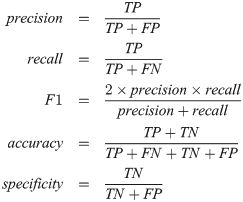


Considerando as métricas f1-score e recall, a melhor arquitetura para predição das duas classes é o Adaboost com BOW e TF-IDF, pois apresenta >59% para recall e f1-score, destacando-se o recall de 77% para a classe positiva com BOW, um dos melhores scores. Assim, este modelo tem a melhor perfomance em acertar a classificação das amostras com menor taxa de falsos negativos 

Adaboost com BOW: 

              precision    recall  f1-score   support

          -1       0.72      0.61      0.66       993
           1       0.67      0.77      0.72      1018


Random Forest com BOW obteve o melhor score de recall: 83% para sentimentos positivos, porém muito baixo para a classe negativa, apenas 53%.


Random Forest com BOW: 

                precision    recall  f1-score   support

          -1       0.75      0.53      0.62       993
           1       0.64      0.83      0.72      1018